# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve

In [2]:
rain = pd.read_csv('../data/rain_data_aus.csv', index_col = 0)

In [3]:
rain = pd.read_csv('../data/rain_data_aus.csv')
wind = pd.DataFrame()
for i in range(1,9):
    df_aux = pd.read_csv(f'../data/wind_table_0{i}.csv')
    df_aux.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    wind = pd.concat([wind,df_aux])
rain_wind =  pd.merge(rain, wind, how='left', on=['date', 'location'])

In [4]:
pd.options.display.max_columns = None

In [5]:
rain_wind = rain_wind.drop('amountOfRain', axis = 1)

In [6]:
rain_wind.raintomorrow = rain_wind.raintomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [7]:
rain_wind.raintoday = rain_wind.raintoday.apply(lambda x: 0 if x == 'No' else 1)

In [8]:
rain_wind.date = pd.to_datetime(rain_wind.date)

In [9]:
#rain_wind['Year'] = rain_wind['date'].dt.year

In [10]:
rain_wind['Month'] = rain_wind['date'].dt.month

In [11]:
#rain_wind['Day'] = rain_wind['date'].dt.day

In [12]:
rain_wind.drop('date', axis=1, inplace = True)

In [13]:
from opencage.geocoder import OpenCageGeocode

key = '46b48d2d3d8f4acb88f582e3a83cbe77'
geocoder = OpenCageGeocode(key)

city_lat = {}
city_lng = {}

for city in rain_wind['location'].unique():
    query = f'{city}, Australia'
    results = geocoder.geocode(query)
    city_lat[city] =results[0]['geometry']['lat']
    city_lng[city] =results[0]['geometry']['lng']

In [14]:
cities = pd.DataFrame(data=[city_lat,city_lng]).T
cities = cities.reset_index()
cities.columns= ['location','lat','lng']
rain_wind = pd.merge(left=rain_wind,right=cities,on='location')

In [15]:
rain_wind.drop('location', axis=1, inplace = True)

In [16]:
#dummies_gustdir = pd.get_dummies(rain_wind['wind_gustdir'], drop_first = True, dummy_na=True)
#rain_wind = pd.concat([rain_wind, dummies_gustdir], axis = 1)
rain_wind = rain_wind.drop('wind_gustdir',axis=1)

In [17]:
#dummies_gustdir = pd.get_dummies(rain_wind['wind_dir9am'], drop_first = True, dummy_na=True)
#rain_wind = pd.concat([rain_wind, dummies_gustdir], axis = 1)
rain_wind = rain_wind.drop('wind_dir9am',axis=1)

In [18]:
#dummies_gustdir = pd.get_dummies(rain_wind['wind_dir3pm'], drop_first = True, dummy_na=True)
#rain_wind = pd.concat([rain_wind, dummies_gustdir], axis = 1)
rain_wind = rain_wind.drop('wind_dir3pm',axis=1)

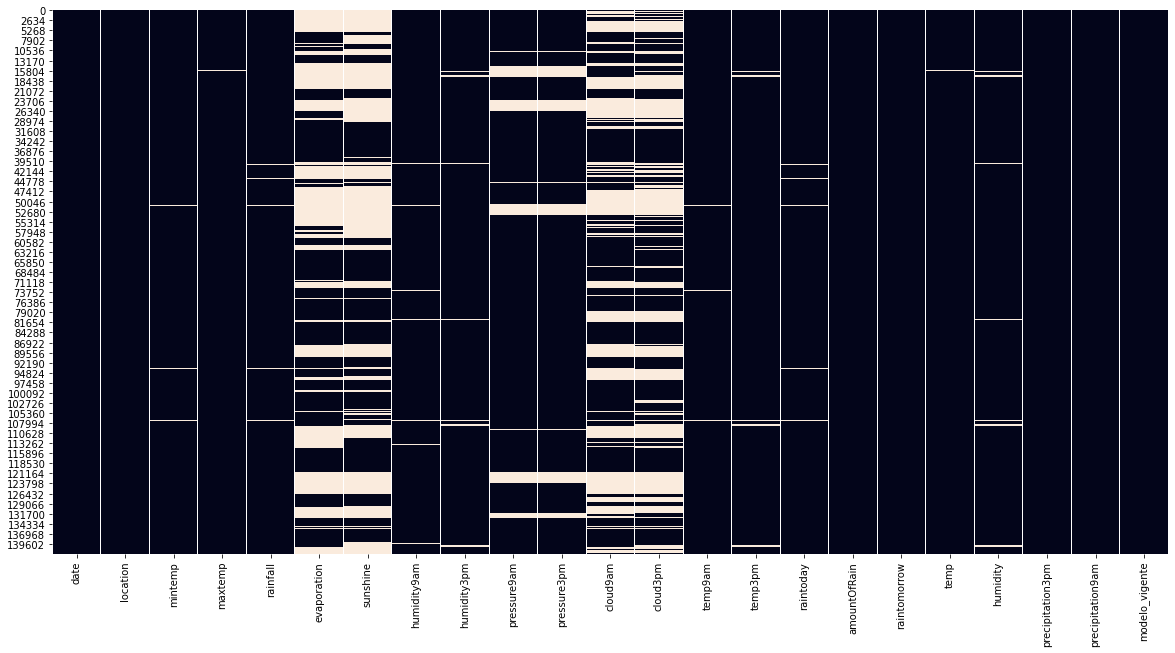

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain.isnull(), cbar=False);

In [231]:
rain_wind.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,wind_gustspeed,wind_speed9am,wind_speed3pm,Month,lat,lng
0,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0,29.48,28.400000,12,5.115360,0.089825,44.0,20.0,24.0,12,-36.080477,146.91628
1,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0,32.12,2.208569,10,21.497100,0.023477,44.0,4.0,22.0,12,-36.080477,146.91628
2,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0,32.84,38.000000,17,20.782859,0.027580,46.0,19.0,26.0,12,-36.080477,146.91628
3,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,0,35.60,21.200000,8,12.028646,0.023962,24.0,11.0,9.0,12,-36.080477,146.91628
4,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,40.76,41.600000,9,11.883546,0.220164,41.0,7.0,20.0,12,-36.080477,146.91628


In [190]:
rain_wind.shape

(164386, 29)

In [20]:
!pwd

/Users/serachung/Desktop/Data_Analytics/Course/Entregas/Projetos/P07-case-itau/case-Itau/processo_cientista


In [21]:
rain_wind.to_csv('../data/rain_wind_lgbm.csv')

In [232]:
y = rain_wind.raintomorrow

In [233]:
rain_wind = rain_wind.drop('raintomorrow', axis=1)

In [234]:
rain_wind = rain_wind.drop('raintoday', axis=1)

In [235]:
rain_wind = rain_wind.drop('modelo_vigente', axis=1)

In [236]:
X = rain_wind

In [201]:
X

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,temp,humidity,precipitation3pm,precipitation9am,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,Month,lat,lng
0,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,29.48,28.400000,12,5.115360,W,44.0,W,WNW,20.0,24.0,12,-36.080477,146.916280
1,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,32.12,2.208569,10,21.497100,WNW,44.0,NNW,WSW,4.0,22.0,12,-36.080477,146.916280
2,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,32.84,38.000000,17,20.782859,WSW,46.0,W,WSW,19.0,26.0,12,-36.080477,146.916280
3,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,35.60,21.200000,8,12.028646,NE,24.0,SE,E,11.0,9.0,12,-36.080477,146.916280
4,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,40.76,41.600000,9,11.883546,W,41.0,ENE,NW,7.0,20.0,12,-36.080477,146.916280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164381,3.6,25.3,0.0,NaN,NaN,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,32.36,27.200000,9,19.715976,NNW,22.0,SE,N,13.0,9.0,6,-25.345554,131.036961
164382,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,34.28,30.800000,12,0.985551,N,37.0,SE,WNW,9.0,9.0,6,-25.345554,131.036961
164383,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,34.28,30.800000,12,0.985551,N,37.0,SE,WNW,9.0,9.0,6,-25.345554,131.036961
164384,7.8,27.0,0.0,NaN,NaN,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,34.40,30.800000,15,4.381481,SE,28.0,SSE,N,13.0,7.0,6,-25.345554,131.036961


In [225]:
rain['precipitation9am'].describe()

count    86304.000000
mean         9.985629
std          5.006742
min        -17.739346
25%          6.627949
50%          9.970490
75%         13.397435
max         32.478590
Name: precipitation9am, dtype: float64

# Train Test Split

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)

# Standardize

In [227]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [11]:
logistic = LogisticRegression(n_jobs=-1)
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

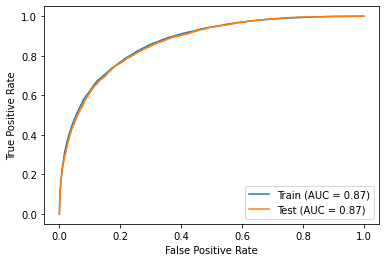

In [12]:
fig, ax = plt.subplots()

plot_roc_curve(logistic, X_train, y_train, ax=ax, name='Train')
plot_roc_curve(logistic, X_test, y_test, ax=ax, name='Test')

# KNN

## Checking best columns

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, KFold

In [32]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [35]:
select = SelectKBest(k=15)
selected = select.fit(X_train, y_train)
ind_selected = selected.get_support(indices=True)
col_selected = [X.columns[i] for i in ind_selected]
print(col_selected)

['rainfall', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp3pm', 'wind_speed9am', 'wind_speed3pm', 'loc_AliceSprings', 'loc_Mildura', 'loc_Portland', 'loc_Woomera', 'wind_dir9am_N']


C:\Users\lzapa\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [16 20 28 30 33 39 40 41 42 46 52 56 59 62] are constant.
  UserWarning)
C:\Users\lzapa\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [41]:
X = rain[['rainfall', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp3pm', 'wind_speed9am', 'wind_speed3pm', 'loc_AliceSprings', 'loc_Mildura', 'loc_Portland', 'loc_Woomera', 'wind_dir9am_N']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

## Default params

In [43]:
knn_default = KNeighborsClassifier(n_jobs=-1)

In [44]:
cross_val_score(knn_default, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')

array([0.83905674, 0.83273931, 0.83548085, 0.82936339, 0.83105491,
       0.82143391, 0.82535783, 0.82238481, 0.82492336, 0.82483457])

In [46]:
knn_default.fit(X_train, y_train)
ypred_knn = knn_default.predict(X_test)
ypred_train_knn = knn_default.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [47]:
roc_dist_knn

{'test': 0.7289126449510854, 'train': 0.7942218977250015}

## Understanding Parameters

### n_neighbors

Number of neighbors to use by default for kneighbors queries.

#### n_neighbors = 10

In [48]:
knn_10 = KNeighborsClassifier(n_neighbors = 10, n_jobs=-1)

In [49]:
knn_10.fit(X_train, y_train)
ypred_knn = knn_10.predict(X_test)
ypred_train_knn = knn_10.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [57]:
roc_dist_knn

{'test': 0.6857405423415193, 'train': 0.6910727412856251}

#### n_neighbors = 100

In [50]:
knn_100 = KNeighborsClassifier(n_neighbors = 100, n_jobs=-1)

In [51]:
knn_100.fit(X_train, y_train)
ypred_knn = knn_100.predict(X_test)
ypred_train_knn = knn_100.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [52]:
roc_dist_knn

{'test': 0.7033904729166431, 'train': 0.7132054431048054}

#### n_neighbors = 1000

In [53]:
knn_1000 = KNeighborsClassifier(n_neighbors = 1000, n_jobs=-1)

In [54]:
knn_1000.fit(X_train, y_train)
ypred_knn = knn_1000.predict(X_test)
ypred_train_knn = knn_1000.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [55]:
roc_dist_knn

{'test': 0.6857405423415193, 'train': 0.6910727412856251}

##### Roc Curve

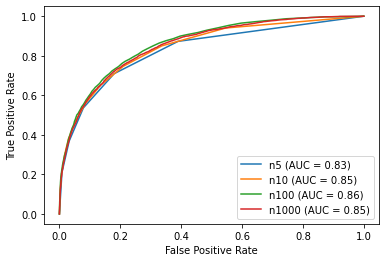

In [56]:
fig, ax = plt.subplots()

plot_roc_curve(knn_default, X_test, y_test, ax=ax, name='n5')
plot_roc_curve(knn_10, X_test, y_test, ax=ax, name = 'n10')
plot_roc_curve(knn_100, X_test, y_test, ax=ax, name = 'n100')
plot_roc_curve(knn_1000, X_test, y_test, ax=ax, name = 'n1000')

### weights

weight function used in prediction. (default = 'uniform')

Using bests AUC score and changing weights parameters

#### n_neighbors = 10 & weights = distance

In [60]:
knn_10 = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)

In [61]:
knn_10.fit(X_train, y_train)
ypred_knn = knn_10.predict(X_test)
ypred_train_knn = knn_10.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [62]:
roc_dist_knn

{'test': 0.7689194726115309, 'train': 1.0}

#### n_neighbors = 100 & weights = distance

In [63]:
knn_100 = KNeighborsClassifier(n_neighbors=100, weights='distance', n_jobs=-1)

In [64]:
knn_100.fit(X_train, y_train)
ypred_knn = knn_100.predict(X_test)
ypred_train_knn = knn_100.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [65]:
roc_dist_knn

{'test': 0.7643615080344395, 'train': 1.0}

In [72]:
score=knn_100.score(X,y)
score

0.9731298665183538

In [74]:
score_recall = recall_score(y, knn_100.predict(X))
score_recall

0.9133974481051228

In [75]:
precision_recall = precision_score(y, knn_100.predict(X))
precision_recall

0.9745999491998985

#### n_neighbors = 1000 & weights = distance

In [66]:
knn_1000 = KNeighborsClassifier(n_neighbors=1000, weights='distance', n_jobs=-1)

In [67]:
knn_1000.fit(X_train, y_train)
ypred_knn = knn_1000.predict(X_test)
ypred_train_knn = knn_1000.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [68]:
roc_dist_knn

{'test': 0.7495846992603308, 'train': 1.0}

##### Roc Curve

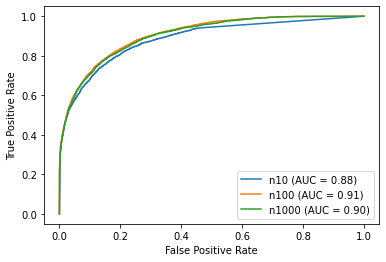

In [69]:
fig, ax = plt.subplots()

plot_roc_curve(knn_10, X_test, y_test, ax=ax, name = 'n10')
plot_roc_curve(knn_100, X_test, y_test, ax=ax, name = 'n100')
plot_roc_curve(knn_1000, X_test, y_test, ax=ax, name = 'n1000')

### p value

Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.



#### n_neighbors = 10 & weights = distance & p = 1

In [94]:
knn_10 = KNeighborsClassifier(n_neighbors=10, p=1, n_jobs=-1)

In [95]:
knn_10.fit(X_train, y_train)
ypred_knn = knn_10.predict(X_test)
ypred_train_knn = knn_10.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [96]:
roc_dist_knn

{'test': 0.7117376796817502, 'train': 0.7396835385398892}

#### n_neighbors = 100 & weights = distance & p = 1

In [119]:
knn_100 = KNeighborsClassifier(n_neighbors=100, p=1, n_jobs=-1)

In [120]:
knn_100.fit(X_train, y_train)
ypred_knn = knn_100.predict(X_test)
ypred_train_knn = knn_100.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [99]:
roc_dist_knn

{'test': 0.7053338682214146, 'train': 0.7123882720889829}

In [105]:
score=knn_100.score(X,y)
score

0.8363922877271042

In [106]:
score_recall = recall_score(y, knn_100.predict(X))
score_recall

0.46662540468482194

In [107]:
precision_recall = precision_score(y, knn_100.predict(X))
precision_recall

0.7706400377417832

#### n_neighbors = 1000 & weights = distance & p = 1

In [100]:
knn_1000 = KNeighborsClassifier(n_neighbors=1000, p=1, n_jobs=-1)

In [101]:
knn_1000.fit(X_train, y_train)
ypred_knn = knn_1000.predict(X_test)
ypred_train_knn = knn_1000.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [102]:
roc_dist_knn

{'test': 0.686859132205451, 'train': 0.6929575313977605}

##### Roc Curve

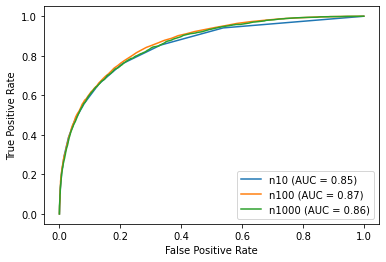

In [103]:
fig, ax = plt.subplots()

plot_roc_curve(knn_10, X_test, y_test, ax=ax, name = 'n10')
plot_roc_curve(knn_100, X_test, y_test, ax=ax, name = 'n100')
plot_roc_curve(knn_1000, X_test, y_test, ax=ax, name = 'n1000')

## knn_100

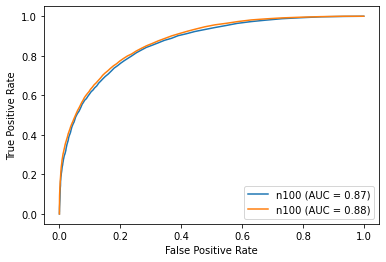

In [104]:
fig, ax = plt.subplots()
plot_roc_curve(knn_100, X_test, y_test, ax=ax, name = 'n100_test')
plot_roc_curve(knn_100, X_train, y_train, ax=ax, name = 'n100_treino')

### n_neighbors = 100 & p = 1 & cross-validation

In [115]:
knn_100 = KNeighborsClassifier(n_neighbors=100, p=1, n_jobs=-1)

In [109]:
results = cross_val_score(knn_100, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8674165829377276, 0.0032831268770128746)

### Best range into n_neighbors

#### n = 50

In [110]:
knn_50 = KNeighborsClassifier(n_neighbors=50, p=1, n_jobs=-1)

In [125]:
results = cross_val_score(knn_50, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8669333520128752, 0.002920485426818128)

In [111]:
knn_50.fit(X_train, y_train)
ypred_knn = knn_50.predict(X_test)
ypred_train_knn = knn_50.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [112]:
roc_dist_knn

{'test': 0.7070376210287566, 'train': 0.7183199585886682}

#### n = 150

In [121]:
knn_150 = KNeighborsClassifier(n_neighbors=150, p=1, n_jobs=-1)

In [126]:
results = cross_val_score(knn_150, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8669062416197704, 0.004035063912027781)

In [122]:
knn_150.fit(X_train, y_train)
ypred_knn = knn_150.predict(X_test)
ypred_train_knn = knn_150.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [123]:
roc_dist_knn

{'test': 0.7030475132989922, 'train': 0.7097018351978822}

##### Roc Curve

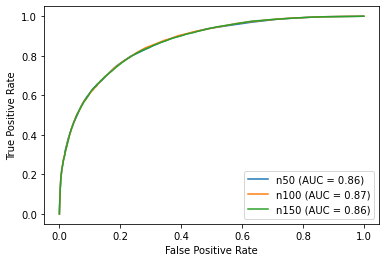

In [124]:
fig, ax = plt.subplots()

plot_roc_curve(knn_50, X_test, y_test, ax=ax, name = 'n50')
plot_roc_curve(knn_100, X_test, y_test, ax=ax, name = 'n100')
plot_roc_curve(knn_150, X_test, y_test, ax=ax, name = 'n150')


#### n = 75

In [228]:
knn_75 = KNeighborsClassifier(n_neighbors=75, p=1, n_jobs=-1)

In [229]:
results = cross_val_score(knn_75, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8736203637180884, 0.0049767067621464215)

In [230]:
knn_75.fit(X_train, y_train)
ypred_knn = knn_75.predict(X_test)
ypred_train_knn = knn_75.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [231]:
roc_dist_knn

{'test': 0.6389791061925386, 'train': 0.6463720364280826}

In [232]:
score=knn_75.score(X,y)
score

0.46739432703003336

In [233]:
score_recall = recall_score(y, knn_75.predict(X))
score_recall

0.837840411350219

In [234]:
precision_recall = precision_score(y, knn_75.predict(X))
precision_recall

0.29252967186409123

ValueError: query data dimension must match training data dimension

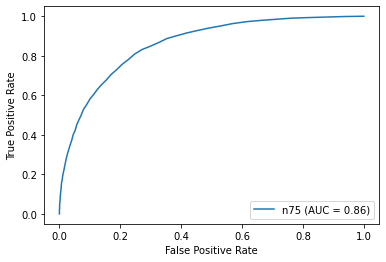

In [235]:
fig, ax = plt.subplots()

plot_roc_curve(knn_75, X_test, y_test, ax=ax, name = 'n75')
plot_roc_curve(knn_100, X_test, y_test, ax=ax, name = 'n100')

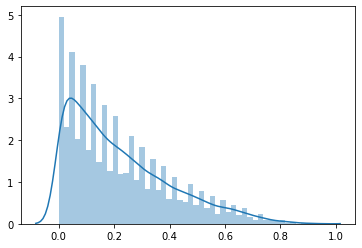

In [236]:
sns.distplot(knn_75.predict_proba(X_test)[:,1])

# LIGHTGBM

In [9]:
lgb = LGBMClassifier(max_depth=1, n_estimators=100, colsample_bytree=.7, n_jobs=-1)

In [11]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8617846825957034, 0.0032758899298883774)

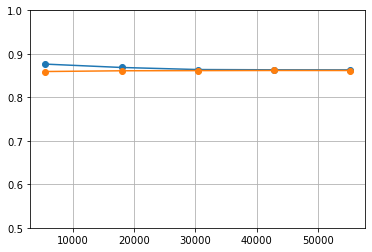

In [12]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

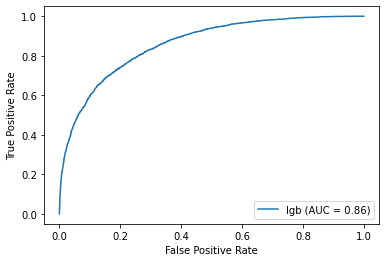

In [14]:
fig, ax = plt.subplots()
lgb.fit(X_train, y_train)
plot_roc_curve(lgb, X_test, y_test, ax=ax, name = 'lgb')

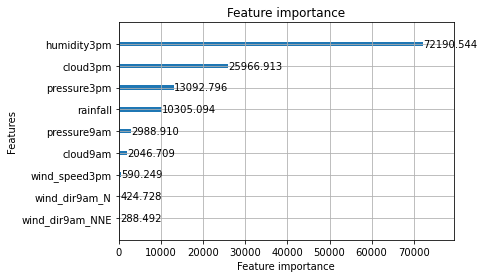

In [16]:
plot_importance(lgb, importance_type='gain')

## Tunning Parameters

### Leaf-wise

num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

max_depth. You also can use max_depth to limit the tree depth explicitly.

#### num_leaves

In [20]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, n_estimators=100, colsample_bytree=.7, n_jobs=-1)

In [21]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8874726876544072, 0.003202247178146454)

#### min_data_in_leaf

In [33]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, n_estimators=100, colsample_bytree=.7, n_jobs=-1)

In [31]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8878974040159763, 0.0036941350745873886)

#### n_estimators

In [47]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, n_estimators=1500, colsample_bytree=.7, n_jobs=-1)

In [48]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.9097713350075057, 0.0033260522948645906)

### For fast speed

In [244]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, n_estimators=1000, 
                     bagging_fraction=1, bagging_freq=3, feature_fraction=1,
                     max_bin=10,
                     colsample_bytree=.7, n_jobs=-1)

In [245]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.9009238641632906, 0.0034522954935850394)

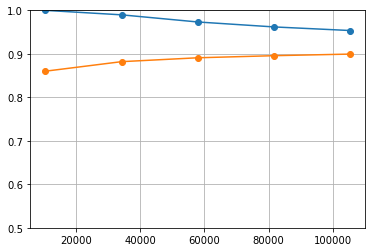

In [246]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

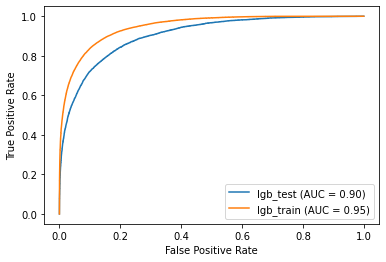

In [247]:
fig, ax = plt.subplots()
lgb.fit(X_train, y_train)
plot_roc_curve(lgb, X_test, y_test, ax=ax, name = 'lgb_test')
plot_roc_curve(lgb, X_train, y_train, ax=ax, name = 'lgb_train')

In [251]:
score=lgb.score(X,y)
score

0.8930565863273028

In [253]:
score_recall = recall_score(y, lgb.predict(X))
score_recall

0.653557546966098

In [255]:
precision_recall = precision_score(y, lgb.predict(X))
precision_recall

0.8361419987568203

In [257]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [258]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

In [259]:
lgb.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=1, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.7, feature_fraction=1,
               importance_type='split', learning_rate=0.1, max_bin=10,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=6, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=32, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [264]:
score=lgb.score(X_test,y_test)
score

0.8692134558063143

In [262]:
score_recall = recall_score(y_val, lgb.predict(X_val))
score_recall

0.5830417227456258

In [263]:
precision_recall = precision_score(y_val, lgb.predict(X_val))
precision_recall

0.7549668874172185

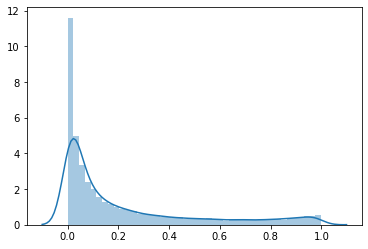

In [265]:
sns.distplot(lgb.predict_proba(X_test)[:,1])

## Dividing by Clusters

In [319]:
rw = pd.read_csv('../data/rw_clean.csv', index_col=0)

In [320]:
rw = rw.drop('date', axis=1)

In [321]:
rw = rw.drop('wind_dir3pm', axis=1)

In [322]:
rw = rw.drop('modelo_vigente', axis=1)

In [323]:
rw = rw.drop('location', axis=1)

In [420]:
rw0 = rw[(rw['cluster_1'] == 0)]
rw1 = rw[(rw['cluster_1'] == 1)]
rw2 = rw[(rw['cluster_1'] == 2)]
rw3 = rw[(rw['cluster_1'] == 3)]

In [416]:
rw0.shape

(23677, 30)

In [412]:
rw1.shape

(15475, 30)

In [413]:
rw2.shape

(14538, 30)

In [415]:
rw3.shape

(14538, 30)

### Cluster = 0

In [374]:
rw0['raintomorrow'].sum()

2720

In [401]:
rw0 = rw0.drop(['lat', 'lng', 'cluster_1', 'cluster_2', 'cluster_3_x', 'cluster_3_y', 'cluster_3'], axis=1)

In [402]:
rw0.head(1)

,rainfall,humidity3pm,pressure3pm,temp3pm,raintomorrow,wind_speed3pm,month,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
6507,0.0,13.0,1004.4,33.4,0,20.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [403]:
y = rw0.raintomorrow

In [404]:
X = rw0.drop('raintomorrow', axis=1)

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)

In [406]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, 
                     learning_rate=0.001, n_estimators=1000, 
                     bagging_fraction=1, bagging_freq=2, feature_fraction=1,
                     max_bin=5,
                     colsample_bytree=.7, n_jobs=-1)

In [407]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.876323684888531, 0.010188644206963922)

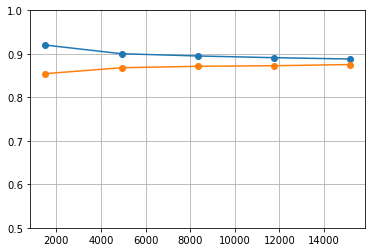

In [408]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

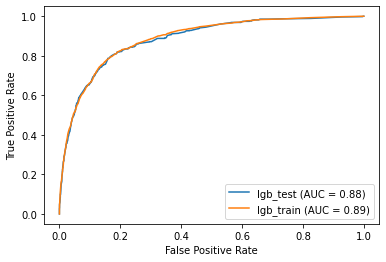

In [409]:
fig, ax = plt.subplots()
lgb.fit(X_train, y_train)
plot_roc_curve(lgb, X_test, y_test, ax=ax, name = 'lgb_test')
plot_roc_curve(lgb, X_train, y_train, ax=ax, name = 'lgb_train')

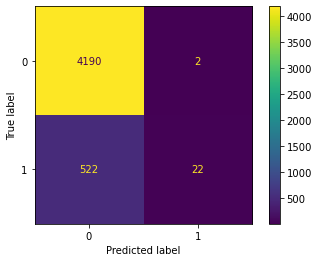

In [410]:
plot_confusion_matrix(lgb, X_test, y_test, values_format='.0f')

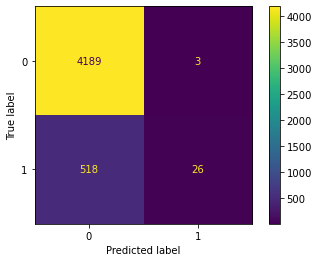

In [364]:
plot_confusion_matrix(lgb, X_test, y_test, values_format='.0f')

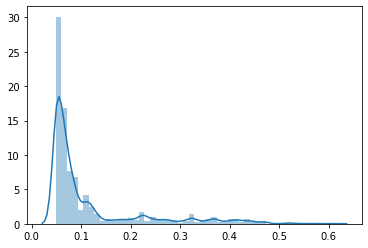

In [411]:
sns.distplot(lgb.predict_proba(X_test)[:,1])

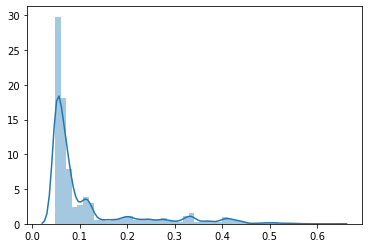

In [371]:
sns.distplot(lgb.predict_proba(X_test)[:,1])

In [387]:
y_pred = lgb.predict_proba(X_test)[:,1] > 0.1

In [388]:
y_pred

array([False,  True, False, ..., False, False, False])

In [389]:
confusion_matrix(y_test, y_pred)

array([[3211,  981],
       [  84,  460]], dtype=int64)

In [394]:
precision_score(y_test, y_pred)

0.3192227619708536

In [396]:
from sklearn.metrics import plot_precision_recall_curve


In [ ]:
plot_precision_recall_curve(lgb, X, y, name='Light')

In [395]:
recall_score(y_test, y_pred)

0.8455882352941176

In [392]:
score=lgb.score(X_test,y_pred)
score

0.7018581081081081

In [382]:
score_recall = recall_score(y, lgb.predict(X))
score_recall

0.04779411764705882

In [365]:
precision_recall = precision_score(y, lgb.predict(X))
precision_recall

0.9285714285714286

In [374]:
rw0['raintomorrow'].sum()

2720

In [421]:
rw1 = rw1.drop(['day', 'lat', 'lng', 'cluster_1', 'cluster_2', 'cluster_3_x', 'cluster_3_y', 'cluster_3'], axis=1)

In [422]:
rw1.head(1)

,rainfall,humidity3pm,pressure3pm,temp3pm,raintomorrow,wind_speed3pm,month,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
108780,0.0,63.0,1015.2,17.9,0,17.0,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [423]:
y = rw1.raintomorrow

In [424]:
X = rw1.drop('raintomorrow', axis=1)

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)

In [426]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, 
                     learning_rate=0.001, n_estimators=1000, 
                     bagging_fraction=1, bagging_freq=2, feature_fraction=1,
                     max_bin=5,
                     colsample_bytree=.7, n_jobs=-1)

In [427]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8900768580961437, 0.015364624031080458)

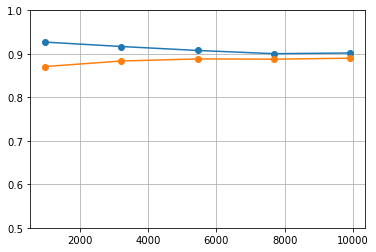

In [428]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

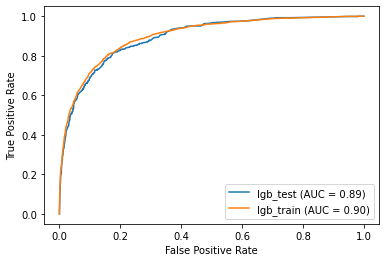

In [429]:
fig, ax = plt.subplots()
lgb.fit(X_train, y_train)
plot_roc_curve(lgb, X_test, y_test, ax=ax, name = 'lgb_test')
plot_roc_curve(lgb, X_train, y_train, ax=ax, name = 'lgb_train')

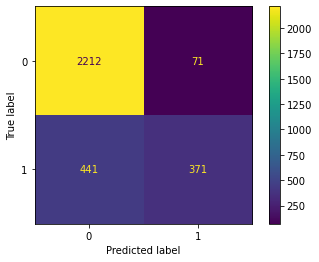

In [430]:
plot_confusion_matrix(lgb, X_test, y_test, values_format='.0f')

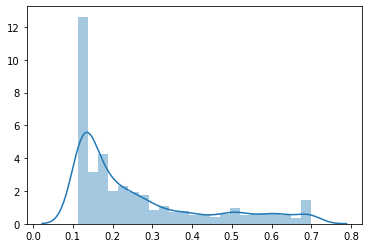

In [431]:
sns.distplot(lgb.predict_proba(X_test)[:,1])

In [442]:
y_pred = lgb.predict_proba(X_test)[:,1] > 0.4

In [443]:
y_pred

array([False, False, False, ..., False, False, False])

In [444]:
confusion_matrix(y_test, y_pred)

array([[2158,  125],
       [ 342,  470]], dtype=int64)

In [436]:
recall_score(y_test, y_pred)

0.7266009852216748

In [435]:
precision_score(y_test, y_pred)

0.6820809248554913

In [437]:
score=lgb.score(X,y)
score

0.8394184168012924

In [396]:
from sklearn.metrics import plot_precision_recall_curve


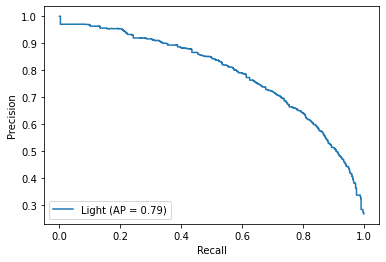

In [438]:
plot_precision_recall_curve(lgb, X, y, name='Light')